In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [45]:
train_df = pd.read_csv("Data/train.csv")
test_df = pd.read_csv("Data/test.csv")

In [46]:
missing_values_train = train_df.isnull().sum() / len(train_df) * 100
missing_values_test = test_df.isnull().sum() / len(test_df) * 100

cols_to_drop = set(missing_values_train[missing_values_train > 50].index)
cols_to_drop.update({'Id', 'LandContour', 'LotConfig', 'LotFrontage', 'Street', 'LotShape', 'LandSlope', 'YearBuilt', 'RoofStyle', 'RoofMatl', 
                     'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                     'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 
                     'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                     'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageCars', 'PavedDrive', 'WoodDeckSF', 
                     '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'Condition1', 'Condition2','HouseStyle'})

train_df.drop(columns=cols_to_drop, inplace=True)

cols_to_drop = set(missing_values_test[missing_values_test > 50].index)
cols_to_drop.update({'Id', 'LandContour', 'LotConfig', 'LotFrontage', 'Street', 'LotShape', 'LandSlope', 'YearBuilt', 'RoofStyle', 'RoofMatl', 
                     'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                     'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 
                     'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                     'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageCars', 'PavedDrive', 'WoodDeckSF', 
                     '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'Condition1', 'Condition2','HouseStyle'})

test_df.drop(columns=cols_to_drop, inplace=True)

def encode_quality_df(df):
    # Funkcja zamienia wartości jakościowe na liczby w całym DataFrame.
    mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, 
               'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0, 
               'N': 0, 'Y': 1, 'Fin': 3, 'RFn': 2, 'Unf': 1, 
               'Typ': 5, 'Min1': 4, 'Min2': 4, 'Mod': 3, 'Maj1': 2, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
    return df.replace(mapping).fillna(0)
    

ms_subclass_mapping = {
    20: "1-STORY 1946 & NEWER ALL STYLES",
    30: "1-STORY 1945 & OLDER",
    40: "1-STORY W/FINISHED ATTIC ALL AGES",
    45: "1-1/2 STORY - UNFINISHED ALL AGES",
    50: "1-1/2 STORY FINISHED ALL AGES",
    60: "2-STORY 1946 & NEWER",
    70: "2-STORY 1945 & OLDER",
    75: "2-1/2 STORY ALL AGES",
    80: "SPLIT OR MULTI-LEVEL",
    85: "SPLIT FOYER",
    90: "DUPLEX - ALL STYLES AND AGES",
    120: "1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
    150: "1-1/2 STORY PUD - ALL AGES",
    160: "2-STORY PUD - 1946 & NEWER",
    180: "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
    190: "2 FAMILY CONVERSION - ALL STYLES AND AGES"
}
train_df["MSSubClass"] = train_df["MSSubClass"].map(ms_subclass_mapping)
test_df["MSSubClass"] = test_df["MSSubClass"].map(ms_subclass_mapping)

# print("Usunięte kolumny: ", list(cols_to_drop))
train_df = encode_quality_df(train_df)
train_df = pd.get_dummies(train_df, columns=['MSZoning'], dtype=int)
train_df = pd.get_dummies(train_df, columns=['BldgType'], dtype=int)
train_df = pd.get_dummies(train_df, columns=['Neighborhood'], dtype=int)
train_df = pd.get_dummies(train_df, columns=['MSSubClass'], dtype=int)

test_df = encode_quality_df(test_df)
test_df = pd.get_dummies(test_df, columns=['MSZoning'], dtype=int)
test_df = pd.get_dummies(test_df, columns=['BldgType'], dtype=int)
test_df = pd.get_dummies(test_df, columns=['Neighborhood'], dtype=int)
test_df = pd.get_dummies(test_df, columns=['MSSubClass'], dtype=int)

# Po get_dummies na train_df i test_df
train_columns = train_df.columns
test_df = test_df.reindex(columns=train_columns, fill_value=0)


X = train_df.drop(columns=['SalePrice'])
y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=5000, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Zamiast squared=False:
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

print("\nRandom Forest Regressor:")
print(f"RMSE: {mean_squared_error(y_test, y_pred_rf):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred_rf):.4f}")

C:\Users\zboro\AppData\Local\Temp\ipykernel_24720\4286245363.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(mapping).fillna(0)
C:\Users\zboro\AppData\Local\Temp\ipykernel_24720\4286245363.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(mapping).fillna(0)


MSE: 926230509.40
RMSE: 30434.04

Random Forest Regressor:
RMSE: 926230509.40
R2 Score: 0.8792


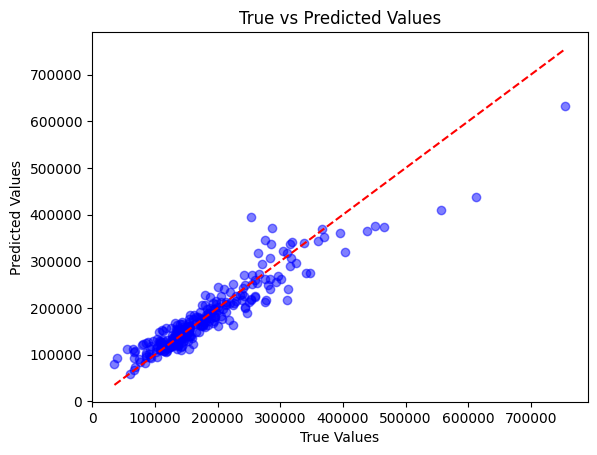

In [47]:
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()